В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження датасета

In [4]:
# Зчитуємо тренувальний датасет
raw_df = pd.read_csv("C:/Users/Ivanna/Documents/Dataset/bank-customer-churn-prediction-dlu-course-c-4/train.csv")
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [5]:
raw_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  str    
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  str    
 5   Gender           15000 non-null  str    
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), str(3)
memory usage: 1.9 MB


In [6]:
raw_df.isnull().any()

id                 False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [7]:
raw_df.Exited.value_counts()

Exited
0.0    11948
1.0     3052
Name: count, dtype: int64

In [8]:
raw_df.Exited.value_counts(normalize=True)

Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64

In [9]:
raw_df.nunique()

id                 15000
CustomerId          6348
Surname              764
CreditScore          378
Geography              3
Gender                 2
Age                   56
Tenure                11
Balance             3395
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     6242
Exited                 2
dtype: int64

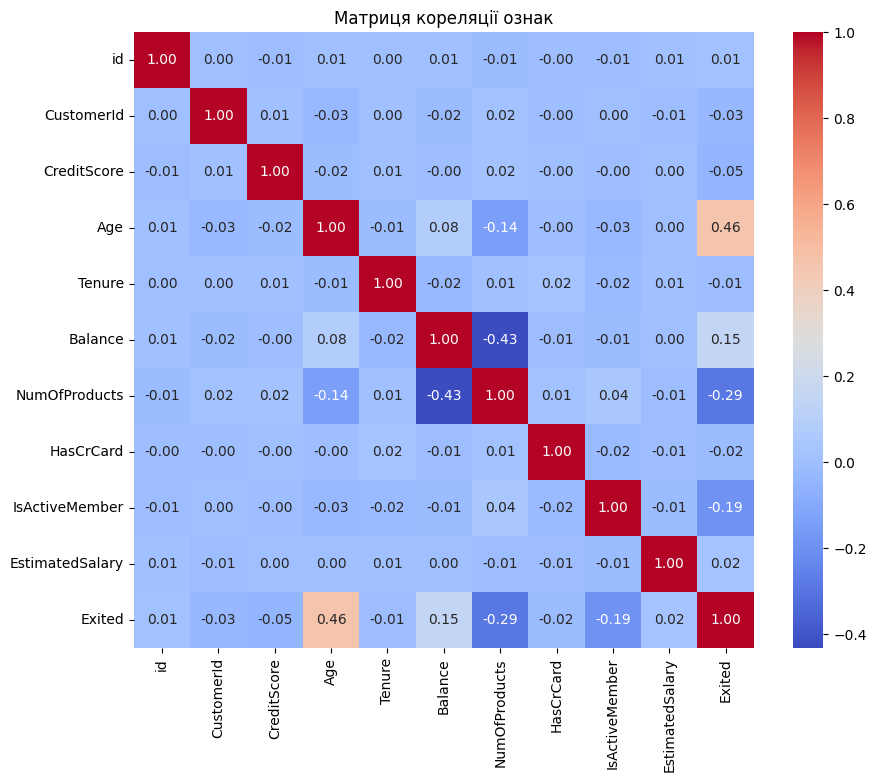

In [36]:
corr_matrix = raw_df.select_dtypes(include=['number']).corr()

# 2. Будуємо хітмап
plt.figure(figsize=(10, 8)) # задаємо розмір графіка
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Матриця кореляції ознак")
plt.show()

**Спостереження**
- Всі дані заповнені, що економить нам час.
- Стовпець `Exited` розподілений 80:20, далі цю пропорцію потрібно зберегти при розбитті на тренувальний та валідаційний датасети.
- Для першої ітерації можна побудувати модель без id, CustomerId та Surname.
- З матриці кореляцій прослідковується звязок ознак Age, NumOfProducts, IsActiveMember, Balance та цільової змінної. Цікаво буде в самій моделі подивитись коефіцієнти.

# Поділ на тренувальний та верифікаційний датасети

In [37]:
from sklearn.model_selection import train_test_split

# Розбиваємо на тренувальний та верифікаційний датасети, пропорційно до таргет стовпця
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

In [38]:
train_df.Exited.value_counts(normalize=True)

Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64

In [39]:
val_df.Exited.value_counts(normalize=True)

Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64

In [13]:
print(f"Розмір тренувального датафрейму: {train_df.shape}")
print(f"Розмір валідаційного датафрейму: {val_df.shape}")

Розмір тренувального датафрейму: (12000, 14)
Розмір валідаційного датафрейму: (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

# Створення незалежних змінних та цільової

In [40]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7180,7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,0.0
10393,10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,0.0
80,80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0
3365,3365,15780572.0,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0
12236,12236,15642099.0,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,0.0


In [41]:
input_cols = list(raw_df.columns)[:-1]
target_col = 'Exited'

In [42]:
print(f"Всього є {len(input_cols)} колонок, що сформують незалежні дані: {input_cols}.")
print(f"Цільова змінна: {target_col}.")

Всього є 13 колонок, що сформують незалежні дані: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'].
Цільова змінна: Exited.


In [43]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [44]:
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
print(f"Числові колонки: {numeric_cols}")
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
print(f"Категоріальні колонки: {categorical_cols}")

Числові колонки: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Категоріальні колонки: ['Surname', 'Geography', 'Gender']


C:\Users\Ivanna\AppData\Local\Temp\ipykernel_24392\2809180180.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = train_inputs.select_dtypes('object').columns.tolist()


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

# Вилучення ознак

В першій ітерації побудуємо модель без врахування ознак 
- id, CustomerId - додаватимуть тільки "шуму" моделі
- Surname - його потрібно детальніше вивчити, щоб закодувати.

In [45]:
 input_cols, numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'Surname',
  'CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

In [46]:
def remove_cols(lst, to_delete):
    for col in to_delete:
        if col in lst:
            lst.remove(col)

col_for_delete = ['id', 'CustomerId', 'Surname']

remove_cols(input_cols, col_for_delete)
remove_cols(numeric_cols, col_for_delete)
remove_cols(categorical_cols, col_for_delete)

In [47]:
 input_cols, numeric_cols, categorical_cols

(['CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

# Масштабування числових ознак

In [48]:
train_inputs[numeric_cols].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,658.840250,37.687917,5.026083,43008.174363,1.590250,0.790333,0.491583,117992.400015
std,72.334909,8.138440,2.781974,59906.627660,0.532646,0.407088,0.499950,45589.484607
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83343.730000
50%,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123613.910000
75%,708.000000,42.000000,7.000000,109949.050000,2.000000,1.000000,1.000000,156912.810000
max,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000


Використаємо MinMaxScaler з sklearn.preprocessing, щоб масштабувати значення до діапазону [0, 1]. Масштабування числових ознак забезпечує, що жодна конкретна ознака не має непропорційного впливу на втрати моделі. 

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


In [51]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [52]:
# перевіримо тепер числові стовпці
display(train_inputs[numeric_cols].describe().round(2))
display(val_inputs[numeric_cols].describe().round(2))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.54,0.35,0.50,0.21,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,0.55,0.36,0.50,0.20,0.20,0.78,0.48,0.58
std,0.17,0.15,0.28,0.28,0.18,0.41,0.50,0.23
min,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.41
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.61
75%,0.66,0.43,0.70,0.51,0.33,1.00,1.00,0.78
max,1.00,0.96,1.00,0.89,1.00,1.00,1.00,1.00


# Кодування категоріальних даних

In [53]:
train_inputs[categorical_cols].nunique()

Geography    3
Gender       2
dtype: int64

In [54]:
train_inputs['Gender'].value_counts()

Gender
Male      6876
Female    5124
Name: count, dtype: int64

Використаємо one-hot кодування.

In [56]:
from sklearn.preprocessing import OneHotEncoder

In [57]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')

In [58]:
# застосування фіт енкодера до тестовго набору
encoder.fit(train_inputs[categorical_cols])

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20",'auto'
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",'if_binary'
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",False
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'ignore'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `.",None
,"m

In [59]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [60]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [61]:
encoder.transform(train_inputs[categorical_cols])[:10]

array([[1., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 1.],
       [1., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [1., 0., 0., 0.]])

In [63]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [64]:
display(train_inputs.head())
display(val_inputs.head())

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,7180,15652218.0,Mays,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,1.0
10393,10393,15592937.0,Ch'eng,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,0.0
80,80,15774586.0,Ch'in,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,1.0
3365,3365,15780572.0,K?,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,1.0
12236,12236,15642099.0,Trevisani,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,1.0


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
6490,6490,15794345.0,Pirozzi,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,1.0
3646,3646,15617348.0,Ritchie,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,1.0
5306,5306,15787907.0,Hs?eh,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,0.0
652,652,15803378.0,Onio,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,0.0
2627,2627,15772423.0,Genovesi,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

# Збереження даних у форматі `parquet`

In [66]:
import os
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [67]:
# Зберігаємо інпути
train_inputs.to_parquet(f'{data_dir}/train_inputs.parquet')
val_inputs.to_parquet(f'{data_dir}/val_inputs.parquet')

# Зберігаємо таргети (оскільки це Series, перетворюємо в DataFrame)
pd.DataFrame(train_targets).to_parquet(f'{data_dir}/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet(f'{data_dir}/val_targets.parquet')

In [68]:
os.listdir(data_dir)

['train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

# Навчання моделі

In [71]:
numeric_cols, encoded_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Male'])

In [72]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [73]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

## Коефіцієнти та передбачення таргета

In [75]:
model.coef_.round(2)

array([[-0.88,  8.45, -0.08, -1.1 , -3.94, -0.19, -1.25,  0.19, -1.03,
         0.54, -1.12, -0.86]])

In [76]:
print(model.intercept_)

[-1.60464126]


In [110]:
train_preds = model.predict(X_train)
train_preds[:5]

array([0., 0., 0., 0., 0.])

In [78]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.98536749, 0.01463251],
       [0.72911631, 0.27088369],
       [0.87257622, 0.12742378],
       ...,
       [0.99276294, 0.00723706],
       [0.83144071, 0.16855929],
       [0.94939177, 0.05060823]], shape=(12000, 2))

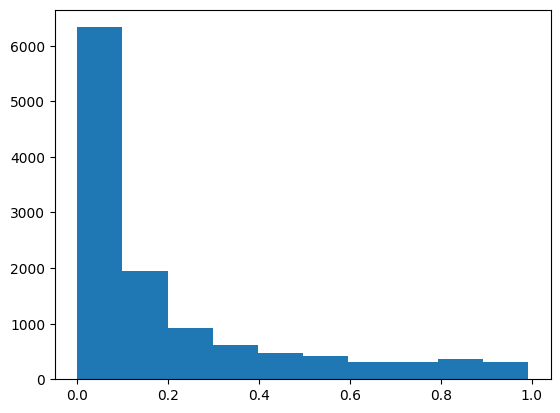

In [79]:
plt.hist(train_probs[:,1])
plt.show()

## Розрахунок accuracy_score

In [80]:
from sklearn.metrics import accuracy_score

In [81]:
# для тренувального набору
accuracy_score(train_targets, train_preds)

0.87425

In [82]:
# для валідаційного набору
val_preds = model.predict(X_val)
accuracy_score(val_targets, val_preds)

0.8716666666666667

Модель досягає точності 87,4% на навчальному наборі та 87,2% на валідаційному.

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якість моделі? Вона хороша, погана, задовільна?

## Побудова Confusion matrix

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.9601381 , 0.0398619 ],
       [0.46191646, 0.53808354]])

In [84]:
confusion_matrix(train_targets, train_preds)

array([[9177,  381],
       [1128, 1314]])

In [85]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.42%


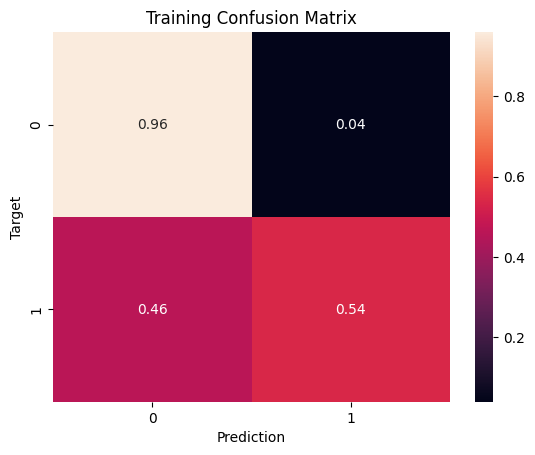

In [86]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.17%


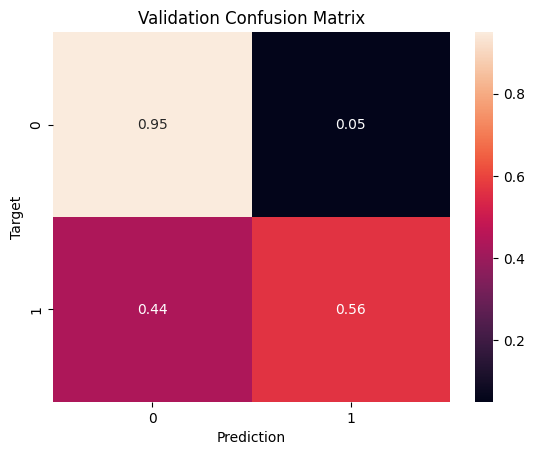

In [87]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

## Обчислення F1

In [88]:
from sklearn.metrics import f1_score

In [89]:
preds = model.predict(X_train)
preds[:5], train_targets[:5]

(array([0., 0., 0., 0., 0.]),
 7180     0.0
 10393    0.0
 80       0.0
 3365     0.0
 12236    0.0
 Name: Exited, dtype: float64)

In [90]:
f1_score(train_targets, preds)

0.6352429296591733

In [91]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.64%


## Побудова ROC Curve та обчислення AUROC

In [92]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

  # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


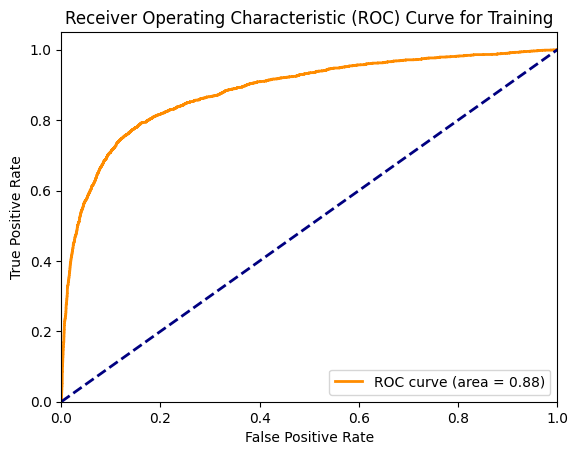

AUROC for Validation: 0.88


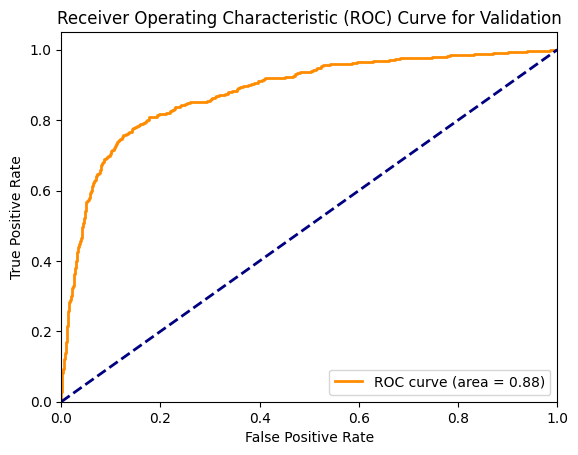

In [93]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

**Спостереження**
- Модель в обох випадках має AUROC = 0.88. Це дуже гарне значення, близьке до 1.
- Але з confusion_matrix видно велику кількість false negative помилок.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

## Передбачення моделі, яка передбачає завжди мажоритарний клас

In [94]:
def all_no(inputs):
    return np.full(len(inputs), 0)

In [96]:
def print_accuracy(targets, preds, name):
  accuracy = accuracy_score(targets, preds)
  print(f"Accuracy score for {name}: {accuracy:.4f}")

In [97]:
print_accuracy(train_targets, all_no(X_train), 'Training for all 0 model')
print_accuracy(val_targets, all_no(X_val), 'Validation for all 0 model')
print_accuracy(train_targets, train_preds, 'Training for model')
print_accuracy(val_targets, val_preds, 'Validation for model')

Accuracy score for Training for all 0 model: 0.7965
Accuracy score for Validation for all 0 model: 0.7967
Accuracy score for Training for model: 0.8742
Accuracy score for Validation for model: 0.8717


**Спостереження**
- Наша модель з пункту 6 є кращою, її Accuracy вище приблизно на 8%.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

# Збереження моделі

In [98]:
import joblib

In [99]:
# створимо словник, що містить усі необхідні об'єкти
churn_prediction = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [100]:
# збережемо модель в окрему папку
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'log_reg.joblib')
joblib.dump(churn_prediction, model_path)

['models\\log_reg.joblib']

In [101]:
model_2 = joblib.load(model_path)

In [102]:
model_2

{'model': LogisticRegression(solver='liblinear'),
 'scaler': MinMaxScaler(),
 'encoder': OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False),
 'input_cols': ['CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 'target_col': 'Exited',
 'numeric_cols': ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 'categorical_cols': ['Geography', 'Gender'],
 'encoded_cols': ['Geography_France',
  'Geography_Germany',
  'Geography_Spain',
  'Gender_Male']}

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

# Функція predict_raw_df

In [144]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    # Масштабуємо числа
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    current_encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
    # Трансформуємо категорії та записуємо в нові колонки
    input_df[current_encoded_cols] = encoder.transform(input_df[categorical_cols])

    # Формуємо матрицю ознак
    X_input = input_df[numeric_cols + current_encoded_cols]

    # Прогнозуємо
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [146]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

array([0.00653297, 0.03674711, 0.37092276, 0.37605273, 0.97579676])

In [147]:
raw_df.Exited[:5]

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: Exited, dtype: float64

**Спостереження**
- Модель помилилась на 1 передбачення, якщо трешхолд 0.5.

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

# Модель на тестовому наборі

In [157]:
# Зчитуємо тренувальний датасет
test_raw_df = pd.read_csv("C:/Users/Ivanna/Documents/Dataset/bank-customer-churn-prediction-dlu-course-c-4/test.csv")
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [158]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [159]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,1.0,0.075341
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,1.0,0.035385
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,1.0,0.152962
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,1.0,0.194683
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,1.0,0.055614


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [160]:
# Зчитуємо `sample_submission.csv`
submission_df = pd.read_csv("C:/Users/Ivanna/Documents/Dataset/bank-customer-churn-prediction-dlu-course-c-4/sample_submission.csv")
submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [161]:
submission_log_reg = submission_df[['id']].merge(test_raw_df[['id', 'Exited']], on='id')

In [162]:
submission_log_reg.head()

,id,Exited
0,15000,0.075341
1,15001,0.035385
2,15002,0.152962
3,15003,0.194683
4,15004,0.055614


In [163]:
submission_log_reg.to_csv('submission_log_reg.csv', index=False)